
**Retinal Exudates Segmentation Using Advanced Image Analysis methods and Machine Learning**
> This code is written by:

1.   Husam Nujaim
2.   Tewele Tareke
3.   Anastasiia Rozhyna
4.   Aroz Hada


In [1]:
import numpy as np
import cv2
import os 
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import greycomatrix, greycoprops
from skimage import io
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pandas import ExcelWriter
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import pandas as pd
from skimage.measure import shannon_entropy
import pickle
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from skimage import feature
from skimage.feature import haar_like_feature
from skimage.transform import integral_image
import math 
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_similarity_score
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import auc

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functio

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Training Set
image_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/OriginalImages/TrainingSet/"
Exudates_candidates_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Candidates/Exudates/"
Exudates_Features_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Training/TrainingSet_Exudates11.xlsx'
EX_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TrainingSet/HardExudates/"
SE_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TrainingSet/SoftExudates/"
SE_ConfidenceScore_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Testing/SE_ConfidenceScore.xlsx'
EX_ConfidenceScore_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Testing/EX_ConfidenceScore.xlsx'

EX_masks = os.listdir(EX_mask_path)
SE_masks = os.listdir(SE_mask_path)
EX_candidates = os.listdir(Exudates_candidates_path)

EX_masks.sort()
SE_masks.sort()
EX_candidates.sort()




images = os.listdir(image_path)
EX_masks = os.listdir(EX_mask_path)
SE_masks = os.listdir(SE_mask_path)

images.sort()
EX_masks.sort()
SE_masks.sort()

In [ ]:
Exudates_scaler_filename = "/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Training/ExudatesFull_scaler.save"
Exudates_ML_model_filename = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Training/ExudatesFull_model.save'

***Declaring the functions to be used in the segmentation process***

In [ ]:
# Adaptive histogram equalization  
def clahe_equalized(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl1 = clahe.apply(img)
    return  cl1

# Adjust Gamma
def adjust_gamma(image, gamma=1.0):
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")
   return cv2.LUT(image, table)

#Automatic Image Thresholding using OTSU method
def OTSU(img_gray):
    max_g = 0
    suitable_th = 0
    th_begin = 0
    th_end = 256
    for threshold in range(th_begin, th_end):
        bin_img = img_gray > threshold
        bin_img_inv = img_gray <= threshold
        fore_pix = np.sum(bin_img)
        back_pix = np.sum(bin_img_inv)
        if 0 == fore_pix:
            break
        if 0 == back_pix:
            continue
 
        w0 = float(fore_pix) / img_gray.size
        u0 = float(np.sum(img_gray * bin_img)) / fore_pix
        w1 = float(back_pix) / img_gray.size
        u1 = float(np.sum(img_gray * bin_img_inv)) / back_pix
        # intra-class variance
        g = w0 * w1 * (u0 - u1) * (u0 - u1)
        if g > max_g:
            max_g = g
            suitable_th = threshold
 
    return suitable_th

#Vessels extraction
def vessel(img):
    dst = 255 - img
    clahe = cv2.createCLAHE(clipLimit=0.18,tileGridSize=(1,1))
    Ien = clahe.apply(dst)  
    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
    final = cv2.subtract(Ien,opening)
    test =  OTSU(final)
    ret , binary = cv2.threshold (final ,test, test, cv2.THRESH_BINARY) 
    binary = cv2.medianBlur(binary, 3) 
    return binary


#Evaluate the result of the segmentation 
def evaluation(image, mask):
    
    zeros_list_img, one_list_img, zeros_list_mk, one_list_mk = [], [], [], []
    
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            val_mk = mask[i][j]
            val_img  = image[i][j]
            if val_mk == 0:
                zeros_list_mk.append((i,j))
            else:
                one_list_mk.append((i,j))
            if val_img == 0:
                zeros_list_img.append((i,j))
            else:
                one_list_img.append((i,j))
    TP = len(set(one_list_img).intersection(set(one_list_mk)))
    TN = len(set(zeros_list_img).intersection(set(zeros_list_mk)))
    FP = len(set(one_list_img).intersection(set(zeros_list_mk)))
    FN = len(set(zeros_list_img).intersection(set(one_list_mk)))
    P=0
    R=0
    TPR = 0
    TNR = 0
    if (TP+FP) !=0:
      P = TP/(TP + FP)
    if (TP+FN) !=0: 
      R = TP/(TP + FN)
      TPR=R
    if (TN + FP) !=0:
      TNR = TN/(TN + FP)
    return R, P, TPR, TNR 


# Extract the GLCM features of one region 
def GLCM_feature_extractor(region):
    features = pd.DataFrame()
    for i in range(15):
      if i==0: 
        GLCM = greycomatrix(region, [1], [0]) 
      elif i==1:
        GLCM = greycomatrix(region, [2], [0])  
      elif i==2:
        GLCM = greycomatrix(region, [5], [0]) 
      elif i==3:
        GLCM = greycomatrix(region, [8], [0])
      elif i==4:
        GLCM = greycomatrix(region, [12], [0])

      elif i==5:
        GLCM = greycomatrix(region, [1], [np.pi/4]) 
      elif i==6:
        GLCM = greycomatrix(region, [2], [np.pi/4])  
      elif i==7:
        GLCM = greycomatrix(region, [5], [np.pi/4]) 
      elif i==8:
        GLCM = greycomatrix(region, [8], [np.pi/4])
      elif i==9:
        GLCM = greycomatrix(region, [12], [np.pi/4])
      
      elif i==10:
        GLCM = greycomatrix(region, [1], [np.pi/2]) 
      elif i==11:
        GLCM = greycomatrix(region, [2], [np.pi/2])  
      elif i==12:
        GLCM = greycomatrix(region, [5], [np.pi/2]) 
      elif i==13:
        GLCM = greycomatrix(region, [8], [np.pi/2])
      elif i==14:
        GLCM = greycomatrix(region, [12], [np.pi/2])

      GLCM_Energy = greycoprops(GLCM, 'energy')[0]
      features['Energy'+str(i+1)] = GLCM_Energy
      GLCM_corr = greycoprops(GLCM, 'correlation')[0]
      features['Correlation'+str(i+1)] = GLCM_corr       
      GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
      features['Dissimilarity'+str(i+1)] = GLCM_diss       
      GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
      features['Homogeneity'+str(i+1)] = GLCM_hom       
      GLCM_contr = greycoprops(GLCM, 'contrast')[0]
      features['Contrast'+str(i+1)] = GLCM_contr        
    #Add more filters as needed
    entropy = shannon_entropy(region)
    features['Entropy'] = entropy
    return features


#Candidates extraction after the image processing is done 
def candidates_selection2(original_img,rimg,im_mask_ex,im_mask_se):
    contours, hierarchy = cv2.findContours(rimg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    idx =0 
    t_features = pd.DataFrame()
    t_labels = [] 
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        roi=rimg[y:y+h,x:x+w]
        cv2.rectangle(originalImage,(x,y),(x+w,y+h),(0,255,255),5)
        regions_img=rimg[y:y+h, x:x+w]
        regions_ex=im_mask_ex[y:y+h, x:x+w]
        regions_se=im_mask_se[y:y+h, x:x+w]
        S_ex,p,tpr,tnr = evaluation(regions_img, regions_ex)
        S_se,p,tpr,tnr = evaluation(regions_img, regions_se)
        t_features=t_features.append(feature_extractor(cv2.cvtColor(original_img[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)))
        if (S_ex > 0.1) and (S_ex >= S_se):
           t_labels.append(1)  #Hard Exudate
        elif (S_se>0.1) and (S_se >= S_ex):
          t_labels.append(2)   #Soft Exudate
        else:
          t_labels.append(0)   #Background
    return t_features, t_labels


    return t_features, t_labels
#Local Binary Patterns 
def LBP_feature_extractor(region, numPoints,radius, eps=1e-7):
    df= pd.DataFrame() ;
    lbp = feature.local_binary_pattern(region, numPoints,radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, numPoints + 3),
                             range=(0, numPoints + 2))
    for i in range(hist.shape[0]):
      df['LBP_'+str(i+1)] =[hist[i]]
    return df

#Geometric Shape Features  
def Shape_feature_extractor(region, w,h):
    shp_features= pd.DataFrame()
    M = cv2.moments(region)
    for i in range(4):
      for j in range(4):
        if i==0 and j==0:
          shp_features['m00'] = [M['m00']]
        elif i+j <=3:
          shp_features['m'+str(i)+''+str(j)] = [M['m'+str(i)+''+str(j)]]

    shp_features['nu20'] = [M['nu20']]
    shp_features['nu02'] = [M['nu02']]
    shp_features['nu30'] = [M['nu30']]
    shp_features['nu21'] = [M['nu21']]
    shp_features['nu12'] = [M['nu12']]
    shp_features['nu03'] = [M['nu03']]
    #Hu Moments 
    huMoments = cv2.HuMoments(M)
    for i in range(7):
      shp_features['hu'+str(i+1)] = huMoments[i]

    #Shape features 
    area = cv2.contourArea(region)
    perimeter = cv2.arcLength(region,True)
    eccentricity = w/h #math.sqrt((1- (pow(w, 2)/pow(h, 2)))) #degree of elongation
    shp_features['Area'] = [area]
    shp_features['Perimeter'] =[perimeter]
    shp_features['Eccentricity'] =[eccentricity]
    return shp_features

#Candidates extraction after the image processing is done 
def candidates_selection(original_img,rimg,im_mask_1,im_mask_2):
    contours, hierarchy = cv2.findContours(rimg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    idx =0 
    glcm_features = pd.DataFrame()
    lbp_features = pd.DataFrame()
    shape_features= pd.DataFrame()
    t_labels = [] 
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        roi=rimg[y:y+h,x:x+w]
        #cv2.rectangle(originalImage,(x,y),(x+w,y+h),(0,255,255),5)
        regions_img=rimg[y:y+h, x:x+w]
        regions_1=im_mask_1[y:y+h, x:x+w]
        regions_2=im_mask_2[y:y+h, x:x+w]
        S_1,p,tpr,tnr = evaluation(regions_img, regions_1)
        S_2,p,tpr,tnr = evaluation(regions_img, regions_2)
        b,g,r = cv2.split(original_img)
        #Extract Shape Features 
        shape_features=shape_features.append(Shape_feature_extractor(cnt,w,h))
        #Extract GLCM Features
        glcm_features=glcm_features.append(GLCM_feature_extractor(g[y:y+h, x:x+w]))
        #Extract Local Binary Patterns 
        lbp_features=lbp_features.append(LBP_feature_extractor(g[y:y+h, x:x+w],24, 8))
        #Merge all the features in one data frame 
        t_features = pd.concat([glcm_features, lbp_features, shape_features], axis=1)
        if (S_1 > 0.05) and (S_1 >= S_2):
          t_labels.append(1)  #Microaneurysms
        elif (S_2>0.05) and (S_2 >= S_1):
          t_labels.append(2)   #Hemorrhages
        else:
          t_labels.append(0)   #Background

    return t_features, t_labels


#Utility function to easily plot images
def plot(myimg,mtype="gray"):
  if mtype=="gray":
    plt.imshow(myimg,cmap= mtype)
  else:
    plt.imshow(cv2.cvtColor(myimg, cv2.COLOR_BGR2RGB))
  plt.show()

#Train different ML classifiers 
def train(classifier,X_train,y_train):
    if classifier=='LGBM':
        #Class names for LGBM start at 0 so reassigning labels from 1,2,3,4 to 0,1,2,3
        d_train = lgb.Dataset(X_train, label=y_train)

        # https://lightgbm.readthedocs.io/en/latest/Parameters.html
        lgbm_params = {'learning_rate':0.05, 'boosting_type':'dart',    
                       'objective':'multiclass',
                       'metric': 'multi_logloss',
                       'num_leaves':100,
                       'max_depth':10,
                       'num_class':3}  #no.of unique values in the target class not inclusive of the end value
        my_model = lgb.train(lgbm_params, d_train, 100) #50 iterations. Increase iterations for small learning rates
    elif  classifier=='RF':
        my_model = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight="balanced")
        my_model.fit(X_train, y_train) 
    elif classifier=='SVM':
        my_model = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)

    return my_model

#Predict the classes of the test set 
def predict(mymodel,X_test,y_test):
  test_pred = mymodel.predict(X_test)
  f1=metrics.f1_score(y_test, test_pred, average='weighted')
  df = pd.DataFrame()
  y_test = np.array(y_test)
  y_test = y_test.flatten()
  df['y_test'] = y_test
  df['test_pred'] = test_pred
  writer = ExcelWriter('/content/drive/MyDrive/DRsegmentation/IP_ML/Training/acc_exudates_test.xlsx')
  df.to_excel(writer,'Sheet5')
  writer.save()
  return f1,test_pred

#Print confusion matrix
def CM_plot(y_test, test_pred):
    cm = confusion_matrix(y_test, test_pred)
    fig, ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale=1.6)
    sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

#Extract the exudates (this function is the major functoin of the image processing pipline)
def extract_Exudates(img):
    gray  = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    T, B_Fov = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    b,g,r = cv2.split(img)
    Ienhance = clahe_equalized(g)
    Ienhance =adjust_gamma((255-Ienhance),gamma=2)
    Imedfilter = cv2.medianBlur(Ienhance,211)
    Isub = cv2.subtract(Imedfilter,Ienhance)
    Isub_filter = cv2.blur(Isub,(5,5))
    Isub_filter = cv2.bitwise_and(Isub,B_Fov)
    bestTh = OTSU(Isub_filter)
    T,Idark_tep = cv2.threshold(Isub_filter, bestTh, 255, cv2.THRESH_BINARY)
    sOP = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
    Bdark = cv2.morphologyEx(Idark_tep,cv2.MORPH_OPEN,sOP)

    Imed = cv2.medianBlur(Ienhance,241)
    Isub1 = cv2.subtract(Imed,Ienhance)
    Isub_filter1 = cv2.blur(Isub1,(5,5))
    bestTh1 =  OTSU(Isub_filter1)
    T,Idark_tep1 = cv2.threshold(Isub_filter1, bestTh1, 255, cv2.THRESH_BINARY)
    Bdark1 = cv2.morphologyEx(Idark_tep1,cv2.MORPH_OPEN,sOP)

    Bduel = cv2.bitwise_or(Bdark,Bdark1)

    Ismooth = cv2.GaussianBlur(Ienhance,(7,7),0)
    Ivessel = vessel(Ismooth)
    kernel = np.ones((5, 5), np.uint8)
    Ivessel = cv2.dilate(Ivessel, kernel)

    Bduel = cv2.erode(Bduel,kernel)
    same = cv2.bitwise_and(Ivessel,Bduel)
    result = cv2.subtract(Bduel,same)
    sOP6 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
    result = cv2.morphologyEx(result,cv2.MORPH_OPEN,sOP6)
    result = cv2.erode(result,kernel)

    sOP10 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    result1 = cv2.morphologyEx(result,cv2.MORPH_OPEN,sOP10)

    result = cv2.bitwise_or(result,result1)
    result =  cv2.dilate(result, kernel)
    return result


**Candidates and features extraction from the whole training images**


> This involves: 


1.   Reading the original images with thier corresponding masks
2.   Extract the candidate regions of the hard and soft Exudates 
3.   Extract the GLCM features of each candidate region and save it as a training set for the ML pipline





In [ ]:
train_features = pd.DataFrame()  #the training features 
train_labels = [] #the corresponding lables of the features 
R_evaluation = pd.DataFrame(columns=['img_number', 'EX','SE'])  #the sensitivity evaluation of the exudates in each image in the dataset


#loop through the whole original images of the training set 
for img_number in range(len(images)):
    # Read Image and Mask
    image = image_path + images[img_number]
    ex_mask = EX_mask_path + EX_masks[img_number]
    se_mask = SE_mask_path + SE_masks[img_number]
    original_img = cv2.imread(image)
    mask_ex = cv2.imread(ex_mask)
    mask_se = cv2.imread(se_mask)
    print(img_number,": OriginalImage")
    plot(original_img,"RBG")
    #Load the mask
    im_mask_se = cv2.cvtColor(mask_se, cv2.COLOR_BGR2GRAY)
    th, im_mask_se = cv2.threshold(im_mask_se, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_se)
    im_mask_ex = cv2.cvtColor(mask_ex, cv2.COLOR_BGR2GRAY)
    th, im_mask_ex = cv2.threshold(im_mask_ex, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_ex)

    # segment the exudates
    lesions_segmented = extract_Exudates(img) #Image Processing 
    print(img_number,": lesions_segmented")
    plot(lesions_segmented)
    cv2.imwrite(candidates_path + images[img_number], lesions_segmented)
    # Get the candidates & their GLCM features with lables 
    lesions_segmented = lesions_segmented.astype(np.uint8)
    t_features, t_labels = candidates_selection(original_img,lesions_segmented,im_mask_ex,im_mask_se)
    train_features=train_features.append(t_features)
    train_labels.append(t_labels)
    #Evaluate the result of the image processing (candidate regions). We count on the sensitivity metric in this stage. 
    exR, exP, exTPR, exTNR  = evaluation(lesions_segmented,im_mask_ex)
    seR, seP, seTPR, seTNR  = evaluation(lesions_segmented,im_mask_se)
    R_evaluation.loc[img_number] = [str(img_number+1)] + [exR] +[seR]



**Saving the extracted features into an Excel file to be used as a training set in the ML pipline**

In [ ]:
# Save Training set TO EXCEL
train_data = pd.DataFrame(train_features)
temp=[]
for i in range(len(train_labels)):
  for j in range(len(train_labels[i])):
    temp.append(train_labels[i][j])
train_data['Label'] = np.asarray(temp)
writer = ExcelWriter(Exudates_Features_path)
train_data.to_excel(writer,'Sheet1')
writer.save()

# Save the Evaluation (Sensitivity) of the Image Processing pipline of each image in the training set TO EXCEL
writer = ExcelWriter(Exudates_IP_Evaluation_path)
R_evaluation.to_excel(writer,'Sheet1')
writer.save()

**Machine Learning Pipline**



> **Reading the dataset from the Excel file that we saved earlier**


> **Split the data into training set and test(validation) set**


> **Scaling the features using StandardScaler**


> **Training the ML Classifiers**


> **Evaluating the F1 Score of the classifiers**

In [ ]:
#Reading the Exudates dataset from Excel file 
Exudates_Features_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Training/TrainingSet_Exudates.xlsx'
train_features = pd.read_excel(Exudates_Features_path)
# Undersampling the background samples 
Exudates_FeaturesSmall_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Training/Exudates_small_TS.xlsx'
train_featuresSaved= train_features
s0 = train_features.Label[train_features.Label.eq(0)].sample(30000).index # Undersampling the background
s1 = train_features.Label[train_features.Label.eq(1)].sample(4597).index # 4597 is the full number of samples  of the EX samples in the dataset
s2 = train_features.Label[train_features.Label.eq(2)].sample(175).index # 175 is the full number of samples  of the SE samples in the dataset

train_features = train_features.loc[s0.union(s1).union(s2)]
writer = ExcelWriter(Exudates_FeaturesSmall_path)
train_features.to_excel(writer,'Sheet1')
writer.save() # Saving the new undersampled dataset   
#Reading the undersampled dataset
train_features = pd.read_excel(Exudates_FeaturesSmall_path)
#removing the index column and the label column 
label=train_features['Label']
train_features=train_features.drop(columns="Label")
train_features = train_features.iloc[: , 1:]
train_x = train_features
train_y = pd.DataFrame()
train_y['Label'] = label 

In [ ]:
# Split the data into training set and test(validation) set 
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y,
                                                    stratify=train_y, 
                                                    test_size=0.25)


# Oversampling the minor classes 
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

#Scaling the features using StandardScaler
x = X_over #returns a numpy array
y_train=y_over


#Scaling the features using StandardScaler                                                           
#x = X_train.values #returns a numpy array
stdScaler = preprocessing.StandardScaler()
# Fit on training set only.
stdScaler.fit(x)

# Apply transform to both the training set and the test set.
X_train = stdScaler.transform(x)
X_test = stdScaler.transform(X_test)

#Save the StdScalar to be used in future inference purposes 
joblib.dump(stdScaler, Exudates_scaler_filename) 

#Training the Classifier
classifier = "RF" # It can be "RF" "LGBM" or "SVM" or KNN 
mymodel=train(classifier,X_train,y_train)

#Evaluating the F1 Score of the model on the validation set
f1_score,test_pred = predict(mymodel,X_test,y_test)
print ( "F1 Score = ", f1_score)
target_names = ['B', 'EX', 'SE']
print(classification_report(y_test, test_pred, target_names=target_names))
#Plot the confusion matrix of the predictions
CM_plot(y_test, test_pred)

#Save the ML model to be used in the future 
pickle.dump(mymodel, open(Exudates_ML_model_filename, 'wb'))

**Testing Phase**

> **Initializing the paths of the test set images**


In [ ]:
#Test
image_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/OriginalImages/TestingSet/"
EX_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TestingSet/HardExudates/"
SE_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TestingSet/SoftExudates/"
candidates_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Candidates/TestSet/Exudates/"
Exudates_IP_Evaluation_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Testing/Exudates_IPtest_Evaluation.xlsx'

images = os.listdir(image_path)
EX_masks = os.listdir(EX_mask_path)
SE_masks = os.listdir(SE_mask_path)

images.sort()
EX_masks.sort()
SE_masks.sort()

> **Candidate Regions Extraction from the test images**


In [ ]:
R_evaluation = pd.DataFrame(columns=['img_number', 'EX','SE'])  #the sensitivity evaluation of the exudates in each image in the test dataset
#Loading the ML model to be used to refine the segmentation 
mymodel = pickle.load(open(ML_model_filename, 'rb'))

#loop through the whole original images of the training set 
for img_number in range(len(images)):
    # Read Image and Mask
    image = image_path + images[img_number]
    ex_mask = EX_mask_path + EX_masks[img_number]
    se_mask = SE_mask_path + SE_masks[img_number]
    img = cv2.imread(image)
    mask_ex = cv2.imread(ex_mask)
    mask_se = cv2.imread(se_mask)
    print(img_number,": OriginalImage")
    plot(img,"BrBG")
    #Load and plot the mask
    im_mask_se = cv2.cvtColor(mask_se, cv2.COLOR_BGR2GRAY)
    th, im_mask_se = cv2.threshold(im_mask_se, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_se)
    im_mask_ex = cv2.cvtColor(mask_ex, cv2.COLOR_BGR2GRAY)
    th, im_mask_ex = cv2.threshold(im_mask_ex, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_ex)

    # segment the exudates
    lesions_segmented = extract_Exudates(img)
    print(img_number,": lesions_segmented")
    plot(lesions_segmented)
    cv2.imwrite(candidates_path + images[img_number], lesions_segmented)
    
    #Evaluate the result of the image processing (candidate regions). We bank on the sensitivity metric in this stage. 
    exR, exP, exTPR, exTNR  = evaluation(lesions_segmented,im_mask_ex)
    seR, seP, seTPR, seTNR  = evaluation(lesions_segmented,im_mask_se)
    R_evaluation.loc[img_number] = [str(img_number+1)] + [exR] +[seR]

# Save the evaluation TO EXCEL
writer = ExcelWriter(Exudates_AIA_Evaluation_path)
R_evaluation.to_excel(writer,'Sheet1')
writer.save()


**Segmentation of TEST SET**



> **Declaring the functions to be used**



In [ ]:
#Candidates extraction after the image processing is done and using the ML model to refine the segmentation in the inference stage 
def candidates_extraction_for_inference(img_number,imgorginal, mask1, mask2, rimg,mymodel,scalar):
    contours, hierarchy = cv2.findContours(rimg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    idx =0 
    region_features = [] 
    preds0=[]
    preds1=[]
    segmented_img1 = np.zeros((imgorginal.shape[0],imgorginal.shape[1]))
    segmented_img2 = np.zeros((imgorginal.shape[0],imgorginal.shape[1]))
    segmented_pred0 = np.zeros((imgorginal.shape[0],imgorginal.shape[1]))
    segmented_pred1 = np.zeros((imgorginal.shape[0],imgorginal.shape[1]))
    segmented_pred2 = np.zeros((imgorginal.shape[0],imgorginal.shape[1]))
    confidenceTable1 = pd.DataFrame()
    confidenceTable2 = pd.DataFrame()
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        b,g,r = cv2.split(imgorginal)
        shape_features = pd.DataFrame()
        glcm_features = pd.DataFrame()
        lbp_features = pd.DataFrame()
        t_features = pd.DataFrame()
        confidence_table1 = pd.DataFrame()
        confidence_table2 = pd.DataFrame()

        #Extract Shape Features 
        shape_features=shape_features.append(Shape_feature_extractor(cnt,w,h))
        #Extract GLCM Features
        glcm_features=glcm_features.append(GLCM_feature_extractor(g[y:y+h, x:x+w]))
        #Extract Local Binary Patterns 
        lbp_features=lbp_features.append(LBP_feature_extractor(g[y:y+h, x:x+w],24, 8))
        #Merge all the features in one data frame 
        t_features = pd.concat([glcm_features, lbp_features, shape_features], axis=1)
        #Standard Scalar Transformation
        f= t_features.values
        features=scaler.transform(f)
        #features=pca.transform(features)
        #pred= mymodel.predict(features)
        preds=mymodel.predict_proba(features)
        pred= mymodel.predict(features)
        segmented_pred0[y:y+h, x:x+w] = rimg[y:y+h,x:x+w] * preds[:,0]
        segmented_pred1[y:y+h, x:x+w] = rimg[y:y+h,x:x+w] * preds[:,1]
        segmented_pred2[y:y+h, x:x+w] = rimg[y:y+h,x:x+w] * preds[:,2]
        if pred[0]==1:
          segmented_img1[y:y+h, x:x+w] = rimg[y:y+h,x:x+w]
          confidence_table1.at['0', 'img_number'] = img_number
          confidence_table1['Confidence Score'] = preds[:,1]
          R,P,TPR,TNR = evaluation(mask1[y:y+h, x:x+w], rimg[y:y+h,x:x+w])
          if R >=0.2: 
            confidence_table1['Label'] = 'TP'
          else:
            confidence_table1['Label'] = 'FP'
          confidenceTable1 = confidenceTable1.append(confidence_table1)

        elif pred[0]==2:
          segmented_img2[y:y+h, x:x+w] = rimg[y:y+h,x:x+w]
          confidence_table2.at['0', 'img_number'] = img_number
          confidence_table2['Confidence Score'] = preds[:,2]
          R,P,TPR,TNR = evaluation(mask2[y:y+h, x:x+w], rimg[y:y+h,x:x+w])
          if R >=0.2: 
            confidence_table2['Label'] = 'TP'
          else:
            confidence_table2['Label'] = 'FP'
          confidenceTable2 = confidenceTable2.append(confidence_table2)

    return  segmented_img1,confidenceTable1, segmented_img2, confidenceTable2, segmented_pred0, segmented_pred1, segmented_pred2

def segmentByML(img_number,original_img,mask1, mask2, candidateImage, mymodel,scaler ):
     
  segmented_img1, confidence_table1, segmented_img2, confidence_table2, segmented_pred0, segmented_pred1, segmented_pred2=candidates_extraction_for_inference(img_number, original_img, mask1, mask2,candidateImage,mymodel,scaler)
  return segmented_img1, confidence_table1, segmented_img2, confidence_table2, segmented_pred0,segmented_pred1, segmented_pred2



**Segmentation the whole test set images**

In [ ]:
#Exudats  
scaler = joblib.load(Exudates_scaler_filename) 
mymodel =   pickle.load(open(Exudates_ML_model_filename, 'rb')) 

ex_confidenceTable= pd.DataFrame()
se_confidenceTable= pd.DataFrame()

EX_Segmentation_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/AIA_ML_Segmentation/Segmentation/EX/"
SE_Segmentation_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/AIA_ML_Segmentation/Segmentation/SE/"

EX_ConfidenceImage_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/AIA_ML_Segmentation/ConfidenceImage/Exudates/EX/"
SE_ConfidenceImage_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/AIA_ML_Segmentation/ConfidenceImage/Exudates/SE/"
Exudates_BG_ConfidenceImage_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/AIA_ML_Segmentation/ConfidenceImage/Exudates/BG/"

for img_number in range(len(Exudates_Test_Candidates)):
    seg_img_path= Exudates_Test_candidates_path + Exudates_Test_Candidates[img_number]
    original_path = image_path+images[img_number]
    original_img = cv2.imread(original_path)
    plot(original_img,"RGB")
    ex_mask = EX_mask_path + EX_masks[img_number]
    se_mask = SE_mask_path + SE_masks[img_number]
    mask_ex = cv2.imread(ex_mask)
    mask_se = cv2.imread(se_mask)
    #Load and plot the mask
    im_mask_se = cv2.cvtColor(mask_se, cv2.COLOR_BGR2GRAY)
    th, im_mask_se = cv2.threshold(im_mask_se, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_se)
    im_mask_ex = cv2.cvtColor(mask_ex, cv2.COLOR_BGR2GRAY)
    th, im_mask_ex = cv2.threshold(im_mask_ex, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_ex)

    candidateImage = cv2.imread(seg_img_path)
    candidateImage = cv2.cvtColor(candidateImage, cv2.COLOR_BGR2GRAY)
    th, candidateImage = cv2.threshold(candidateImage, 10, 255, cv2.THRESH_BINARY)
    plot(candidateImage)
    ex_segmented_img, ex_confidence_table, se_segmented_img, se_confidence_table, segmented_pred0, segmented_pred1, segmented_pred2 = segmentByML((img_number+1), original_img,im_mask_ex,im_mask_se,candidateImage,mymodel,scaler)
    ex_confidenceTable = ex_confidenceTable.append(ex_confidence_table)
    se_confidenceTable = se_confidenceTable.append(se_confidence_table)
    
    cv2.imwrite(EX_Segmentation_path + str(img_number)+'.jpg', ex_segmented_img)
    cv2.imwrite(SE_Segmentation_path + str(img_number)+'.jpg', se_segmented_img)

    cv2.imwrite(Exudates_BG_ConfidenceImage_path + str(img_number)+'.jpg', segmented_pred0)
    cv2.imwrite(EX_ConfidenceImage_path + str(img_number)+'.jpg', segmented_pred1)
    cv2.imwrite(SE_ConfidenceImage_path + str(img_number)+'.jpg', segmented_pred2)
    
    plot(ex_segmented_img)
    plot(se_segmented_img)
    plot(segmented_pred0)
    plot(segmented_pred1)
    plot(segmented_pred2)

#Saving the EX_ConfidenceScore
writer = ExcelWriter(EX_ConfidenceScore_path)
ex_confidenceTable.to_excel(writer,'Sheet1')
writer.save()

#Saving the SE_ConfidenceScore
writer = ExcelWriter(SE_ConfidenceScore_path)
se_confidenceTable.to_excel(writer,'Sheet1')
writer.save()


> **Evaluation of the segmentation**




In [ ]:
#Reading the EX_ConfidenceScore and SE_ConfidenceScore
ex_confidenceTable = pd.read_excel(EX_ConfidenceScore_path)
se_confidenceTable = pd.read_excel(SE_ConfidenceScore_path)
#Sorting them based on the Confidence Score
ex_confidenceTable.sort_values('Confidence Score', inplace=True, ascending=False)
se_confidenceTable.sort_values('Confidence Score', inplace=True, ascending=False)


**Counting the number of ground truth objects so as to calculate the recall**

In [ ]:
#Counting the number of ground truth objects so as to calculate the recall 
def countGTobjects(mask):
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:] 
    return len(contours)

EX_GT_Objects = 0 


for img_number in range(len(EX_masks)):
    # Read Image and Mask
    ex_mask = EX_mask_path + EX_masks[img_number]
    mask_ex = cv2.imread(ex_mask)
    im_mask_ex = cv2.cvtColor(mask_ex, cv2.COLOR_BGR2GRAY)
    th, im_mask_ex = cv2.threshold(im_mask_ex, 10, 255, cv2.THRESH_BINARY)
    #print(img_number,": mask")
    #plot(im_mask_ex)
    c=countGTobjects(im_mask_ex)
    EX_GT_Objects=EX_GT_Objects + c
    #print('Objects: = '+ str(c))
print('Total Objects: = '+ str(EX_GT_Objects))


In [ ]:
SE_GT_Objects = 0 
for img_number in range(len(SE_masks)):
    # Read Image and Mask
    se_mask = SE_mask_path + SE_masks[img_number]
    mask_se = cv2.imread(se_mask)
    im_mask_se = cv2.cvtColor(mask_se, cv2.COLOR_BGR2GRAY)
    th, im_mask_se = cv2.threshold(im_mask_se, 10, 255, cv2.THRESH_BINARY)
    #print(img_number,": mask")
    #plot(im_mask_se)
    c=countGTobjects(im_mask_se)
    SE_GT_Objects=SE_GT_Objects + c
    #print('Objects: = '+ str(c))
print('Total Objects: = '+ str(SE_GT_Objects))

**Calculating the Precision and Recall based on the accumlated TP and FP**

In [ ]:
confidenceTableOfEX = pd.DataFrame()

AccTP = 0
AccFP = 0
for index, row in ex_confidenceTable.iterrows():
    ex_confidenceTable2 = pd.DataFrame()
    if row['Label'] =='TP':
        ex_confidenceTable2.at['0', 'TP']  = 1
        ex_confidenceTable2.at['0', 'FP'] = 0
        AccTP = AccTP+1
    elif row['Label'] =='FP':
        ex_confidenceTable2.at['0', 'TP'] = 0
        ex_confidenceTable2.at['0', 'FP'] = 1
        AccFP = AccFP+1
        
    ex_confidenceTable2.at['0', 'AccTP'] =AccTP
    ex_confidenceTable2.at['0', 'AccFP'] =AccFP
    ex_confidenceTable2.at['0', 'Precision'] = AccTP/(AccTP+AccFP)
    ex_confidenceTable2.at['0', 'Recall']= AccTP/EX_GT_Objects
    confidenceTableOfEX = confidenceTableOfEX.append(ex_confidenceTable2)
 
print(AccTP)

In [ ]:
confidenceTableOfSE = pd.DataFrame()

AccTP = 0
AccFP = 0
for index, row in se_confidenceTable.iterrows():
    se_confidenceTable2 = pd.DataFrame()
    if row['Label'] =='TP':
        se_confidenceTable2.at['0', 'TP']  = 1
        se_confidenceTable2.at['0', 'FP'] = 0
        AccTP = AccTP+1
    elif row['Label'] =='FP':
        se_confidenceTable2.at['0', 'TP'] = 0
        se_confidenceTable2.at['0', 'FP'] = 1
        AccFP = AccFP+1
        
    se_confidenceTable2.at['0', 'AccTP'] =AccTP
    se_confidenceTable2.at['0', 'AccFP'] =AccFP
    se_confidenceTable2.at['0', 'Precisoin'] = AccTP/(AccTP+AccFP)
    se_confidenceTable2.at['0', 'Recall']= AccTP/SE_GT_Objects
    confidenceTableOfSE = confidenceTableOfSE.append(se_confidenceTable2)
 
print(AccTP)

In [ ]:
se_confidenceTable

,Unnamed: 0,img_number,Confidence Score,Label
4,0,7,0.90,FP
11,0,13,0.87,FP
5,0,7,0.86,FP
21,0,21,0.82,TP
15,0,14,0.82,TP
16,0,14,0.80,TP
13,0,13,0.79,FP
17,0,14,0.69,TP
2,0,6,0.68,TP
19,0,15,0.66,FP


In [ ]:
confidenceTableOfSE

,TP,FP,AccTP,AccFP,Precisoin,Recall
0,0.0,1.0,0.0,1.0,0.000000,0.000000
0,0.0,1.0,0.0,2.0,0.000000,0.000000
0,0.0,1.0,0.0,3.0,0.000000,0.000000
0,1.0,0.0,1.0,3.0,0.250000,0.026316
0,1.0,0.0,2.0,3.0,0.400000,0.052632
0,1.0,0.0,3.0,3.0,0.500000,0.078947
0,0.0,1.0,3.0,4.0,0.428571,0.078947
0,1.0,0.0,4.0,4.0,0.500000,0.105263
0,1.0,0.0,5.0,4.0,0.555556,0.131579
0,0.0,1.0,5.0,5.0,0.500000,0.131579


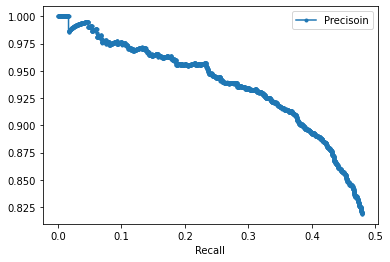

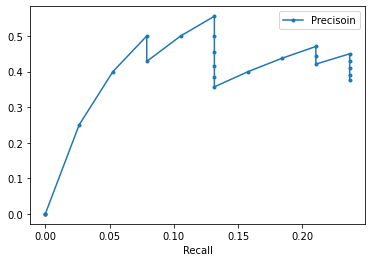

In [ ]:
#Ploting the PR curve 
confidenceTableOfEX.plot(x='Recall', y='Precisoin', marker='.')
confidenceTableOfSE.plot(x='Recall', y='Precisoin', marker='.')


In [ ]:
confidenceTableOfEX

,TP,FP,AccTP,AccFP,Precisoin,Recall
0,1.0,0.0,1.0,0.0,1.000000,0.000243
0,1.0,0.0,2.0,0.0,1.000000,0.000486
0,1.0,0.0,3.0,0.0,1.000000,0.000729
0,1.0,0.0,4.0,0.0,1.000000,0.000972
0,1.0,0.0,5.0,0.0,1.000000,0.001215
...,...,...,...,...,...,...
0,0.0,1.0,1972.0,435.0,0.819277,0.479106
0,1.0,0.0,1973.0,435.0,0.819352,0.479349
0,1.0,0.0,1974.0,435.0,0.819427,0.479592
0,0.0,1.0,1974.0,436.0,0.819087,0.479592




> **Caculating the Area under the PR curve**



In [ ]:
x = []
x = confidenceTableOfEX['Recall']
y_scores = []
y = confidenceTableOfEX['Precisoin']
x = np.array(x)
y = np.array(y)
auc(x=x,y=y)

0.449930048862708

In [ ]:
x = []
x = confidenceTableOfSE['Recall']
y_scores = []
y = confidenceTableOfSE['Precisoin']
x = np.array(x)
y = np.array(y)
auc(x=x,y=y)

0.09418303563345927